# Import Statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import sys
sys.path.append('/cvmfs/icecube.opensciencegrid.org/py3-v4.3.0/RHEL_7_x86_64/lib/python3.11/site-packages/')
import photospline
from photospline import glam_fit, ndsparse, bspline

import site
sys.path.append(site.USER_SITE)
import uproot
from scipy.interpolate import interp1d
import healpy as hp
import glob

# HAWC - Loading and reading in the data

In [2]:
elements = ["proton", "helium", "carbon", "oxygen", "neon", "magnesium", "silicon", "iron"]

files = sorted(glob.glob("pass5.1/*.root"))

main_dict = {e: {} for e in elements}

for e in elements:
    data_candidates = [file for file in files if (e in file) and ('mc' not in file)]
    weight_candidates = [file for file in files if (e in file) and ('mc' in file)]

    # reading the data files
    if len(data_candidates) == 1:
        data_file = data_candidates[0]
        with uproot.open(data_file) as f:
            t = f["XCDF"]
            main_dict[e]["nChAvail"] = t["rec.nChAvail"].array(library="np")
            main_dict[e]["nHit"]      = t["rec.nHit"].array(library="np")
            main_dict[e]["CxPE40XnCh"] = t["rec.CxPE40XnCh"].array(library="np")
            main_dict[e]["corsikaParticleId"] = t["mc.corsikaParticleId"].array(library="np")
            main_dict[e]["zenith"]   = t["rec.zenithAngle"].array(library="np")
            main_dict[e]["coreX"]    = t["rec.coreX"].array(library="np")
            main_dict[e]["coreY"]    = t["rec.coreY"].array(library="np")
            main_dict[e]["coreR"] = np.sqrt((main_dict[e]["coreX"]-37.19)**2+(main_dict[e]["coreY"]-246)**2)/100.
            main_dict[e]["pinc"]     = t["rec.PINC"].array(library="np")
            main_dict[e]["trueEnergy"] = t["mc.logEnergy"].array(library="np")
            # t.show()

    # read the weights files
    if len(weight_candidates) ==1:
        weight_file = weight_candidates[0]
        with uproot.open(weight_file) as f:
            t = f["XCDF"]
            main_dict[e]["gsf"] = t["sweets.IWgt.gsf"].array(library="np")
            main_dict[e]["h3a"] = t["sweets.IWgt.h3a"].array(library="np")

    # defining the initial cuts
    initial_cut = np.logical_and(main_dict[e]["nHit"] > 75, main_dict[e]["zenith"] >= 0)
    initial_cut = np.logical_and(initial_cut, main_dict[e]["zenith"] < 1.222)
    initial_cut = np.logical_and(initial_cut, main_dict[e]["CxPE40XnCh"] > 40)

    # applied the initial cuts here to all the arrays
    for key in main_dict[e].keys():
        main_dict[e][key] = main_dict[e][key][initial_cut]

In [3]:
main_dict

{'proton': {'nChAvail': array([1066,  999, 1074, ..., 1063, 1070,  988], dtype=uint64),
  'nHit': array([333, 998,  86, ..., 235, 110, 976], dtype=uint64),
  'CxPE40XnCh': array([ 99, 211,  65, ..., 112,  57, 135], dtype=uint64),
  'corsikaParticleId': array([14, 14, 14, ..., 14, 14, 14], dtype=uint64),
  'zenith': array([0.1919, 0.2421, 0.0982, ..., 0.727 , 0.8772, 0.0877]),
  'coreX': array([73.4, 29.9, 97.5, ..., 94. , 35.6, 99.1]),
  'coreY': array([176.3, 246.7, 276.2, ..., 255. , 179.8, 262.6]),
  'coreR': array([0.78544599, 0.07323531, 0.67448766, ..., 0.57518485, 0.66219092,
         0.64096865]),
  'pinc': array([3.09, 2.43, 1.46, ..., 1.74, 0.81, 2.37]),
  'trueEnergy': array([3.592, 5.111, 2.494, ..., 3.657, 3.863, 5.075]),
  'gsf': array([1.03459167e-03, 6.58024165e-05, 8.19134620e-04, ...,
         9.65951095e-05, 1.05589482e-03, 1.33738021e-05]),
  'h3a': array([1.05252091e-03, 6.69624836e-05, 8.06668809e-04, ...,
         9.69478026e-05, 1.02743641e-03, 1.36929351e-05])}

In [4]:
# zenith, nHit, nChAvail, coreR, true energy, corsikaParticleID, pinc, gsf, h3a

zenith, nHit, nChAvail, coreR, log_true_E, particleId, pinc, gsf, h3a = [], [], [], [], [], [], [], [], []

for e in main_dict.keys():
    zenith.append(main_dict[e]["zenith"])
    nHit.append(main_dict[e]["nHit"])
    nChAvail.append(main_dict[e]["nChAvail"])
    coreR.append(main_dict[e]["coreR"])
    log_true_E.append(main_dict[e]["trueEnergy"])
    particleId.append(main_dict[e]["corsikaParticleId"])
    pinc.append(main_dict[e]["pinc"])
    gsf.append(main_dict[e]["gsf"])
    h3a.append(main_dict[e]["h3a"])

zenith = np.concatenate(zenith)
nHit = np.concatenate(nHit)
nChAvail = np.concatenate(nChAvail)
coreR = np.concatenate(coreR)
log_true_E = np.concatenate(log_true_E)
particleId = np.concatenate(particleId)
pinc = np.concatenate(pinc)
gsf = np.concatenate(gsf)
h3a = np.concatenate(h3a)

# HAWC - Calculate the reco energy

In [5]:
def get_reco_energy(zenith, nHit, nChAvail, coreR):
    tab1 = photospline.SplineTable(f'pass5_spline_combined3d.fits')
    x = np.cos(zenith)
    y = nHit/nChAvail
    z = coreR

    reco_energy = []

    for i in range(x.size):
        coord3d = [x[i], y[i], z[i]]
        try:
            centers = tab1.search_centers(coord3d)
            reco_energy.append(tab1.evaluate(coord3d, centers))
        except:
            reco_energy.append(-1)

    reco_energy = np.array(reco_energy)

    return reco_energy

In [6]:
reco_energy = get_reco_energy(zenith, nHit, nChAvail, coreR)

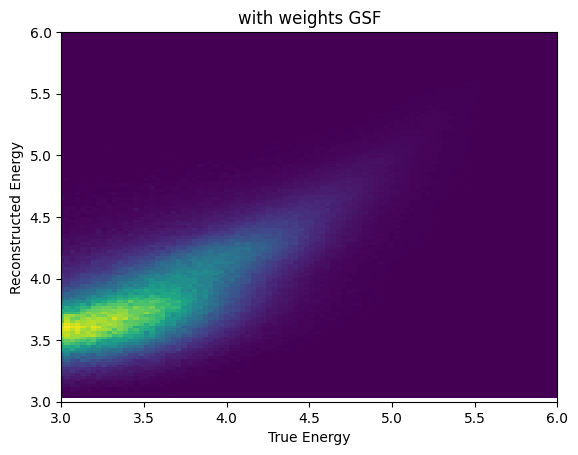

In [7]:
# visualize the reco energy and true energy relation
plt.hist2d(log_true_E, reco_energy, bins = 150, weights = gsf)
plt.ylim(3,6)
plt.xlim(3,6)
plt.xlabel('True Energy')
plt.ylabel('Reconstructed Energy')
plt.title('with weights GSF')
plt.show()

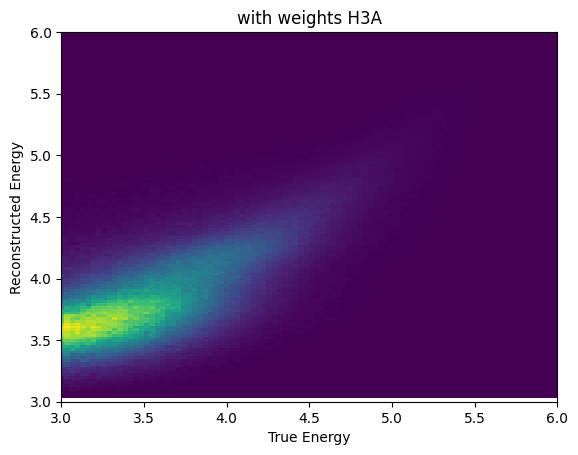

In [8]:
# visualize the reco energy and true energy relation
plt.hist2d(log_true_E, reco_energy, bins = 150, weights = h3a)
plt.ylim(3,6)
plt.xlim(3,6)
plt.xlabel('True Energy')
plt.ylabel('Reconstructed Energy')
plt.title('with weights H3A')
plt.show()

# HAWC - Converting particle IDs to atomic numbers

In [9]:
particle_ids = {14: 1, 402 : 2, 1206 : 6, 2412: 12, 2010 : 10, 1608: 8, 2814: 14, 5626: 26}

In [10]:
atomic_number = []
for i in particleId:
    atomic_number.append(particle_ids[i])

atomic_number = np.array(atomic_number)

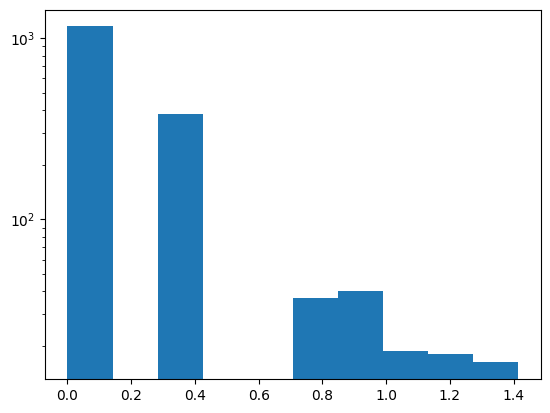

In [11]:
plt.hist(np.log10(atomic_number), weights = gsf)
plt.yscale('log')
plt.show()

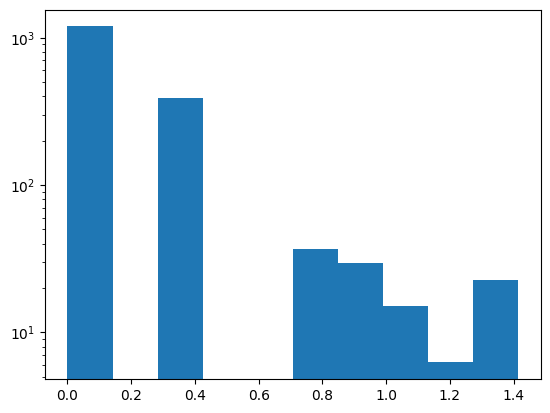

In [12]:
plt.hist(np.log10(atomic_number), weights = h3a)
plt.yscale('log')
plt.show()

In [13]:
# mean_logz = np.average(np.log10(atomic_number), weights = weights)
# mean_logz

# HAWC - Energy cuts on reco energy applied to true energy

- 12 total cuts going from bin0 to bin11

In [14]:
min_energies = [3.0, 3.51, 3.74, 3.98, 4.21, 4.433, 4.648, 4.88, 5.15, 5.44, 5.68, 6.0]
max_energies = [3.51, 3.74, 3.98, 4.21, 4.433, 4.648, 4.98, 5.15, 5.44, 5.68, 6.0, 6.9]
pinc_vals = [1.3, 1.4, 1.5, 1.4, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3]

In [15]:
def cut_energy(min_energy, max_energy, pinc_val):
    cut = np.logical_and(min_energy <= reco_energy, max_energy > reco_energy)
    cut = np.logical_and(cut, pinc > pinc_val)

    return cut

In [16]:
cuts = []

for i , j , k in zip(min_energies, max_energies, pinc_vals):
    cut = cut_energy(i, j , k)
    cuts.append(cut)

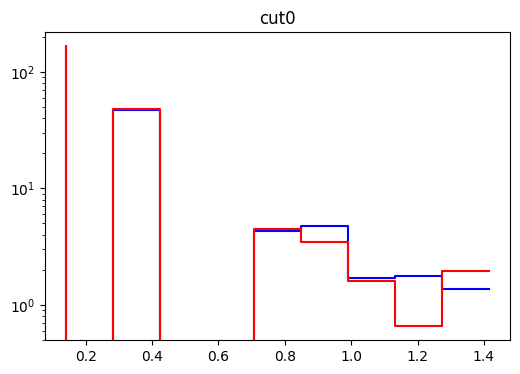

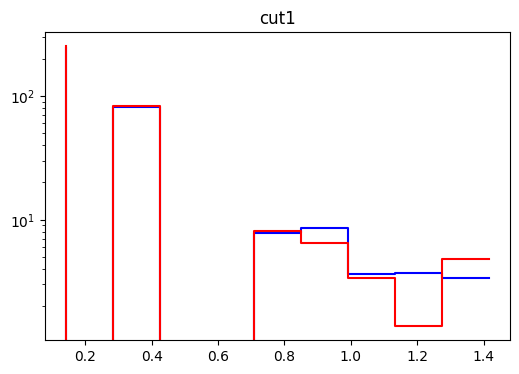

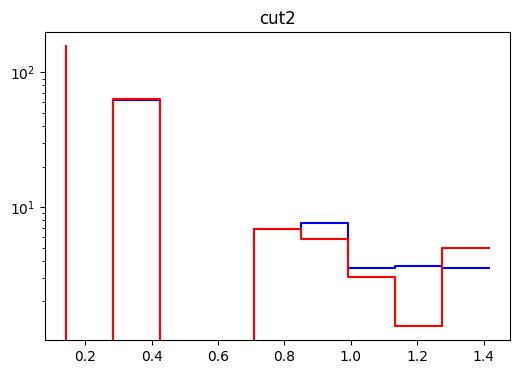

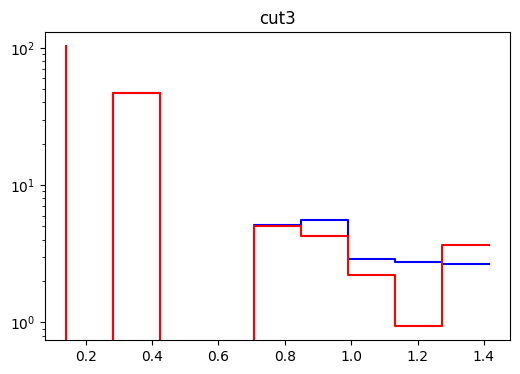

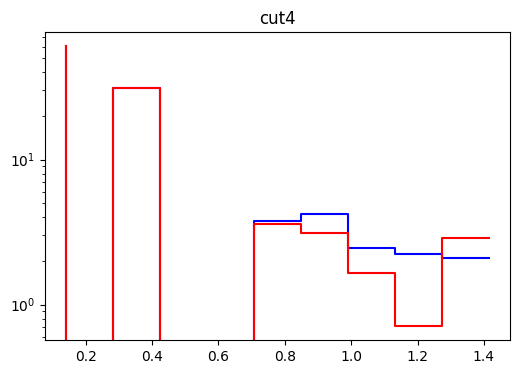

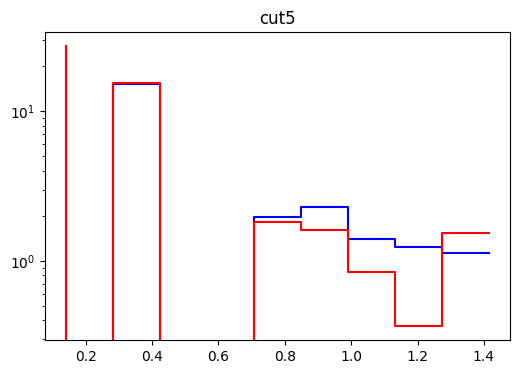

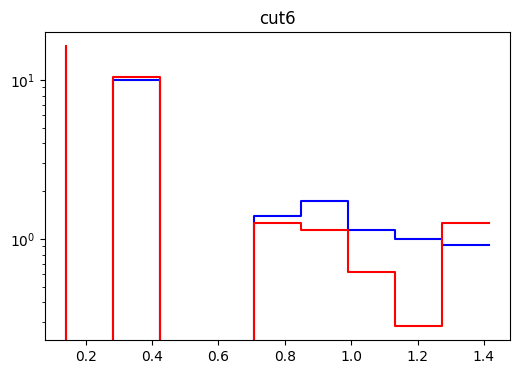

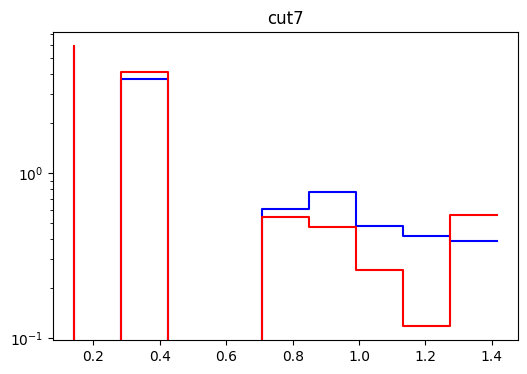

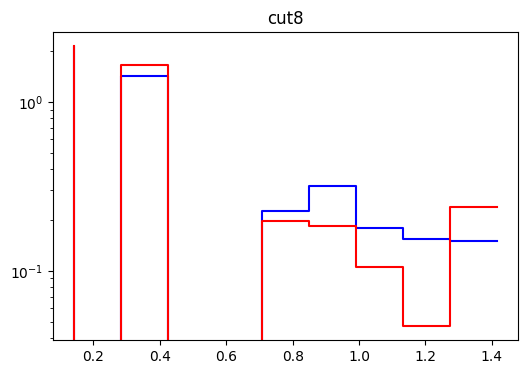

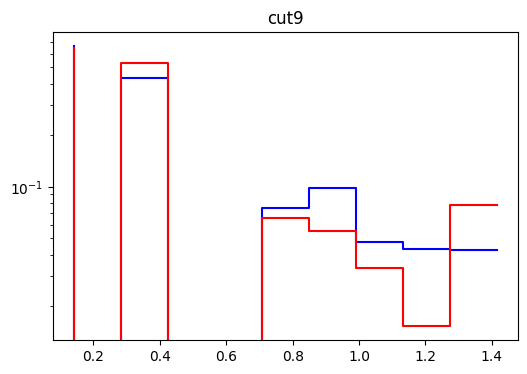

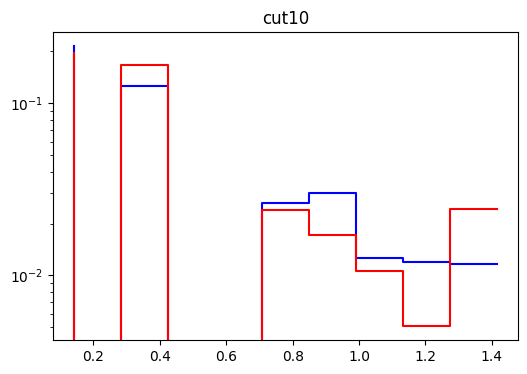

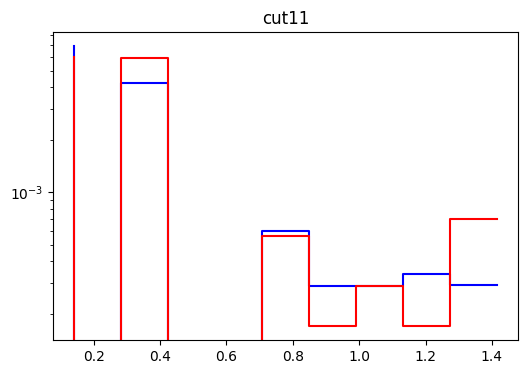

In [17]:
mean_energies_gsf = []
mean_energies_h3a = []
mean_atomic_gsf = []
mean_atomic_h3a = []

for i, cut in enumerate(cuts):
    mean_energy_gsf = np.average(log_true_E[cut], weights = gsf[cut])
    mean_energy_h3a = np.average(log_true_E[cut], weights = h3a[cut])
    mean_logz_gsf = np.average(np.log10(atomic_number[cut]), weights = gsf[cut])
    mean_logz_h3a = np.average(np.log10(atomic_number[cut]), weights = h3a[cut])

    mean_energies_gsf.append(mean_energy_gsf)
    mean_energies_h3a.append(mean_energy_h3a)
    mean_atomic_gsf.append(mean_logz_gsf)
    mean_atomic_h3a.append(mean_logz_h3a)

    bin_gsf, edge_gsf = np.histogram(np.log10(atomic_number[cut]), weights = gsf[cut])
    bin_h3a, edge_h3a = np.histogram(np.log10(atomic_number[cut]), weights = h3a[cut])
    plt.figure(figsize = (6, 4))
    plt.step(edge_gsf[1:], bin_gsf, 'b')
    plt.step(edge_h3a[1:], bin_h3a, 'r')
    plt.yscale('log')
    plt.title(f"cut{i}")
    plt.show()

mean_energies_gsf = np.array(mean_energies_gsf)
mean_energies_h3a = np.array(mean_energies_h3a)
mean_atomic_gsf = np.array(mean_atomic_gsf)
mean_atomic_h3a = np.array(mean_atomic_h3a)

In [18]:
total_n_gsf, total_edges_gsf = np.histogram(log_true_E, bins = mean_energies_gsf, weights = gsf)
total_n_h3a, total_edges_h3a = np.histogram(log_true_E, bins = mean_energies_h3a, weights = h3a)

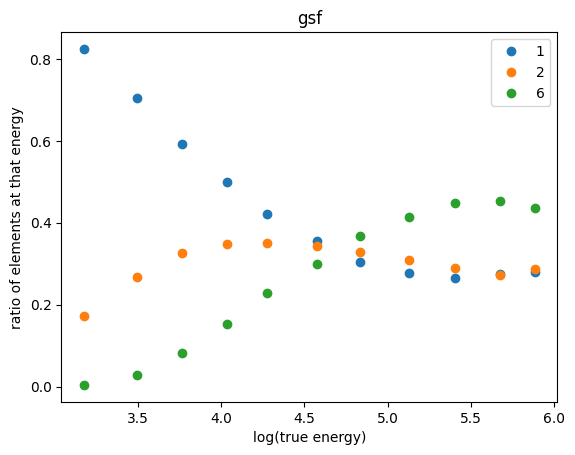

In [19]:
# for i in np.unique(atomic_number):
# gsf
for i in [1,2,6]:
    if i >= 6:
        ni, ei = np.histogram(log_true_E[atomic_number >= i], bins = mean_energies_gsf, weights = gsf[atomic_number >= i])
    else:
        ni, ei = np.histogram(log_true_E[atomic_number == i], bins = mean_energies_gsf, weights = gsf[atomic_number == i])

    frac = ni/total_n_gsf
    plt.plot(ei[1:], frac, 'o',label=str(i))
plt.title("gsf")
plt.xlabel("log(true energy)")
plt.ylabel("ratio of elements at that energy")
plt.legend()
plt.show()

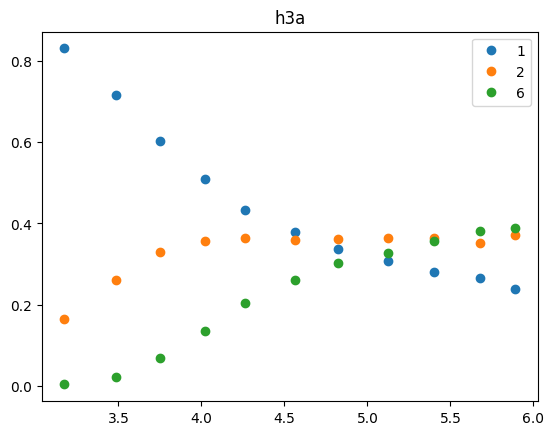

In [20]:
# h3a
for i in [1,2,6]:
    if i >= 6:
        ni, ei = np.histogram(log_true_E[atomic_number >= i], bins = mean_energies_h3a, weights = h3a[atomic_number >= i])
    else:
        ni, ei = np.histogram(log_true_E[atomic_number == i], bins = mean_energies_h3a, weights = h3a[atomic_number == i])

    frac = ni/total_n_h3a
    plt.plot(ei[1:], frac, 'o',label=str(i))
plt.title("h3a")
plt.legend()
plt.show()

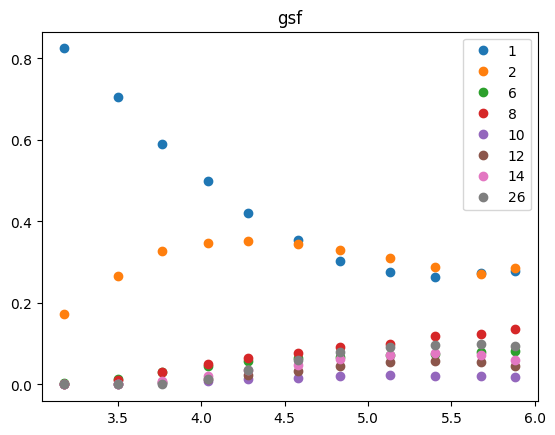

In [21]:
# gsf
for i in np.unique(atomic_number):
    ni, ei = np.histogram(log_true_E[atomic_number == i], bins = mean_energies_gsf, weights = gsf[atomic_number == i])

    frac = ni/ total_n_gsf
    plt.plot(ei[1:], frac, 'o', label = str(i))

plt.title("gsf")
plt.legend()
plt.show()

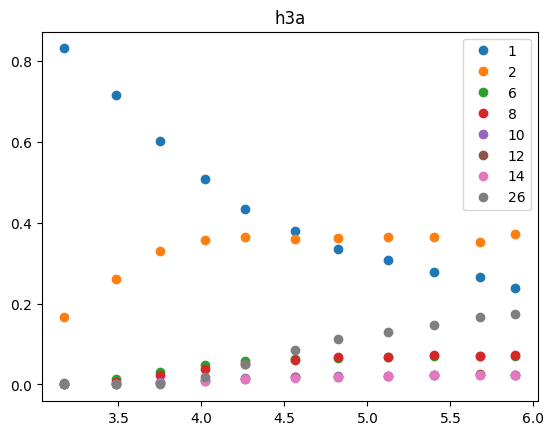

In [22]:
# h3a
for i in np.unique(atomic_number):
    ni, ei = np.histogram(log_true_E[atomic_number == i], bins = mean_energies_h3a, weights = h3a[atomic_number == i])

    frac = ni/ total_n_h3a
    plt.plot(ei[1:], frac, 'o', label = str(i))

plt.title("h3a")
plt.legend()
plt.show()

In [23]:
mean_rid_gsf = mean_energies_gsf - mean_atomic_gsf
mean_rid_gsf

array([2.80205048, 3.03208803, 3.31438517, 3.56712851, 3.80969053,
       4.02567307, 4.28745949, 4.51749759, 4.80888662, 5.08947799,
       5.37691748, 5.64234591])

In [24]:
mean_rid_h3a = mean_energies_h3a - mean_atomic_h3a
mean_rid_h3a

array([2.81710572, 3.03712762, 3.31220047, 3.56421796, 3.81369619,
       4.03916496, 4.31332902, 4.54941748, 4.8367598 , 5.10255633,
       5.37360702, 5.61040444])

# IceCube - Reading and viewing the files

- nchannel: number of active channels
- llhZen: reconstructed zenith
- llhAz: reconstructed azimuth
- zenith: zenith angle
- azimuth: azimuth angle
- mc_energy: true energy
- type: proton, helium, nitrogen, aluminium, iron
- energy: true energy
- GaisserH3a: weights
- Hoerandel: weights
- GlobalFitGST: weights
- reco_energy: reconstructed energy

In [25]:
dst = np.load('dst_20904_v2.npz')

print(dst.files)

# accessing individual numpy arrays from the file
# dst['zenith']

['nchannel', 'llhZen', 'llhAz', 'zenith', 'azimuth', 'mc_energy', 'type', 'isgoodllh', 'ndir', 'ldir', 'rlogl', 'atmosphere', 'TriggID_1006', 'energy', 'GaisserH3a', 'Hoerandel', 'GlobalFitGST', 'GlobalSplineFit5Comp', 'reco_energy']


[4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 6, 6.5]

bin edges in log for the reco energy

# IceCube - Applying initial cuts

In [26]:
imain_cut = np.logical_and(dst['nchannel'] > 10, dst['llhZen'] < 70)

ienergy = np.log10(dst['energy'][imain_cut])
weights_h3a = dst['GaisserH3a'][imain_cut]
# weights_2 = dst['Hoerandel'][imain_cut]
weights_gsf = dst['GlobalSplineFit5Comp'][imain_cut]
ireco_energy = dst['reco_energy'][imain_cut]
inchannel = dst['nchannel'][imain_cut]
ireco_zenith = dst['llhZen'][imain_cut]
izenith = dst['zenith'][imain_cut]
itype = dst['type'][imain_cut]

iparticle_ids = {2212: 1, 1000020040: 2, 1000070140: 7, 1000130270: 13, 1000260560: 26}

In [27]:
iatomic = []
for i in itype:
    iatomic.append(iparticle_ids[i])

iatomic = np.array(iatomic)

# IceCube - Binning the data

## approach
- argsort on reco_energy
- apply it on all the other arrays
- traverse through reco_energy
- find emin and emax for it
- get those indices between emin and emax, including emin and excluding emax
- define that as a cut
- apply that cut on true energy and weights
- get mean energy and mean atomic
- get mean ridgidity
- compare it with HAWC's mean ridgidity
- find the min of all the comparisions
- store the emin and emax as a tuple to use later

In [28]:
# argsort on reco_energy and apply it to all the other arrays
sorted_idx_reco_energy = np.argsort(ireco_energy)
ienergy = ienergy[sorted_idx_reco_energy]
iatomic = iatomic[sorted_idx_reco_energy]
weights_gsf = weights_gsf[sorted_idx_reco_energy]
weights_h3a = weights_h3a[sorted_idx_reco_energy]
ireco_energy = ireco_energy[sorted_idx_reco_energy]

In [29]:
N = len(ireco_energy)

cumW_gsf = np.concatenate(([0.0], np.cumsum(weights_gsf)))
cumW_h3a = np.concatenate(([0.0], np.cumsum(weights_h3a)))
cumE_gsf = np.concatenate(([0.0], np.cumsum(weights_gsf * ienergy)))
cumE_h3a = np.concatenate(([0.0], np.cumsum(weights_h3a * ienergy)))
cumL_gsf = np.concatenate(([0.0], np.cumsum(weights_gsf * np.log10(iatomic))))
cumL_h3a = np.concatenate(([0.0], np.cumsum(weights_h3a * np.log10(iatomic))))

In [30]:
j_indices = np.searchsorted(ireco_energy, ireco_energy + 0.25, side='left')

In [31]:
def compute_mean_rid(j_indices, cumW, cumE, cumL, reco):

    # initialize the arrays
    candidate_rid = np.full(N, np.nan)
    candidate_emin = np.full(N, np.nan)
    candidate_emax = np.full(N, np.nan)
    candidate_mean_E = np.full(N, np.nan)
    candidate_mean_L = np.full(N, np.nan)

    # find the valid indices
    valid_idx = np.where(j_indices > np.arange(N))[0]

    for i in valid_idx:
        j = j_indices[i]
        weight_sum = cumW[j] - cumW[i]
        if weight_sum <= 0:
            continue
        weighted_E = (cumE[j] - cumE[i]) / weight_sum
        weighted_L = (cumL[j] - cumL[i]) / weight_sum
        candidate_mean_E[i] = weighted_E
        candidate_mean_L[i] = weighted_L
        candidate_rid[i] = weighted_E - weighted_L
        candidate_emin[i] = reco[i]
        candidate_emax[i] = reco[j - 1]

    return candidate_rid[valid_idx], candidate_emin[valid_idx], candidate_emax[valid_idx], candidate_mean_E[valid_idx], candidate_mean_L[valid_idx]

In [32]:
# for gsf

valid_candidate_rid_gsf, valid_emin_gsf, valid_emax_gsf, valid_mean_E_gsf, valid_mean_L_gsf = compute_mean_rid(j_indices, cumW_gsf, cumE_gsf, cumL_gsf, ireco_energy)

In [33]:
# for h3a

valid_candidate_rid_h3a, valid_emin_h3a, valid_emax_h3a, valid_mean_E_h3a, valid_mean_L_h3a = compute_mean_rid(j_indices, cumW_h3a, cumE_h3a, cumL_h3a, ireco_energy)

In [34]:
def get_best_cuts(valid_candidate_rid, valid_emin, valid_emax, mean_rid_hawc, valid_mean_E, valid_mean_L):
    store_cuts = []
    mean_rid_vals = []
    # min_diff_values = []
    mean_E_vals = []
    mean_L_vals = []

    for target in mean_rid_hawc:
        differences = np.abs(valid_candidate_rid - target)
        best_idx = np.argmin(differences)
        best_cut = (valid_emin[best_idx], valid_emax[best_idx])
        best_rid = valid_candidate_rid[best_idx]
        store_cuts.append(best_cut)
        mean_rid_vals.append(best_rid)
        mean_E_vals.append(valid_mean_E[best_idx])
        mean_L_vals.append(valid_mean_L[best_idx])
        # min_diff_values.append(differences[best_idx])

    return store_cuts, mean_rid_vals, mean_E_vals, mean_L_vals

In [35]:
# gsf
icuts_gsf, mean_irid_gsf, mean_E_gsf, mean_L_gsf = get_best_cuts(valid_candidate_rid_gsf, valid_emin_gsf, valid_emax_gsf, 
                                                                 mean_rid_gsf, valid_mean_E_gsf, valid_mean_L_gsf)

In [36]:
#h3a
icuts_h3a, mean_irid_h3a, mean_E_h3a, mean_L_h3a = get_best_cuts(valid_candidate_rid_h3a, valid_emin_h3a, valid_emax_h3a, mean_rid_h3a, 
                                                                valid_mean_E_h3a, valid_mean_L_h3a)

In [37]:
def icecube_cut_energy(icut, reco):
    cut = np.logical_and(reco >= icut[0], reco < icut[1])
    return cut

In [38]:
icecube_cuts_gsf = []

for i in icuts_gsf:
    cut = icecube_cut_energy(i, ireco_energy)
    icecube_cuts_gsf.append(cut)

In [39]:
icecube_cuts_h3a = []

for i in icuts_h3a:
    cut = icecube_cut_energy(i, ireco_energy)
    icecube_cuts_h3a.append(cut)

# HAWC + IceCube combined tables

In [40]:
# rigidity and energy bins table
df1 = pd.DataFrame()

df1['HAWC mean rid gsf'] = mean_rid_gsf
df1['HAWC mean rid h3a'] = mean_rid_h3a
df1['HAWC (emin, emax)'] = list(zip(min_energies, max_energies))
df1['IceCube mean rid gsf'] = mean_irid_gsf
df1['IceCube mean rid h3a'] = mean_irid_h3a
df1['IceCube (emin, emax) gsf'] = icuts_gsf
df1['IceCube (emin, emax) h3a'] = icuts_h3a
df1

,HAWC mean rid gsf,HAWC mean rid h3a,"HAWC (emin, emax)",IceCube mean rid gsf,IceCube mean rid h3a,"IceCube (emin, emax) gsf","IceCube (emin, emax) h3a"
0,2.802050,2.817106,"(3.0, 3.51)",3.955562,3.955434,"(3.880659818649292, 4.130659580230713)","(3.880659818649292, 4.130659580230713)"
1,3.032088,3.037128,"(3.51, 3.74)",3.955562,3.955434,"(3.880659818649292, 4.130659580230713)","(3.880659818649292, 4.130659580230713)"
2,3.314385,3.312200,"(3.74, 3.98)",3.955562,3.955434,"(3.880659818649292, 4.130659580230713)","(3.880659818649292, 4.130659580230713)"
3,3.567129,3.564218,"(3.98, 4.21)",3.955562,3.955434,"(3.880659818649292, 4.130659580230713)","(3.880659818649292, 4.130659580230713)"
4,3.809691,3.813696,"(4.21, 4.433)",3.955562,3.955434,"(3.880659818649292, 4.130659580230713)","(3.880659818649292, 4.130659580230713)"
5,4.025673,4.039165,"(4.433, 4.648)",4.025661,4.039163,"(3.9870543479919434, 4.237049579620361)","(4.001307487487793, 4.25128173828125)"
6,4.287459,4.313329,"(4.648, 4.98)",4.287459,4.313336,"(4.306577205657959, 4.556575775146484)","(4.324601173400879, 4.574600696563721)"
7,4.517498,4.549417,"(4.88, 5.15)",4.517498,4.549417,"(4.624240398406982, 4.874239921569824)","(4.644816875457764, 4.894796848297119)"
8,4.808887,4.836760,"(5.15, 5.44)",4.808887,4.836760,"(4.99198579788208, 5.241982936859131)","(5.013888835906982, 5.2638840675354)"
9,5.089478,5.102556,"(5.44, 5.68)",5.089142,5.102553,"(5.382532119750977, 5.632499694824219)","(5.3845295906066895, 5.634518146514893)"


In [41]:
# mean energies table
df2 = pd.DataFrame()

df2['HAWC gsf'] = mean_energies_gsf
df2['HAWC h3a'] = mean_energies_h3a
df2['IceCube gsf'] = mean_E_gsf
df2['IceCube h3a'] = mean_E_h3a
df2

,HAWC gsf,HAWC h3a,IceCube gsf,IceCube h3a
0,2.924925,2.933412,4.081079,4.068491
1,3.177632,3.173304,4.081079,4.068491
2,3.498662,3.483471,4.081079,4.068491
3,3.765163,3.747871,4.081079,4.068491
4,4.037776,4.021894,4.081079,4.068491
5,4.278022,4.264069,4.155163,4.156541
6,4.577322,4.566182,4.443149,4.456985
7,4.832388,4.823598,4.715526,4.736127
8,5.130292,5.125443,5.062315,5.090788
9,5.401556,5.400572,5.421052,5.448705


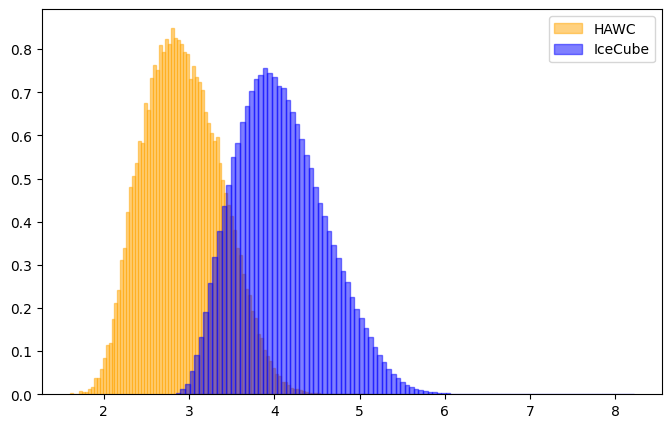

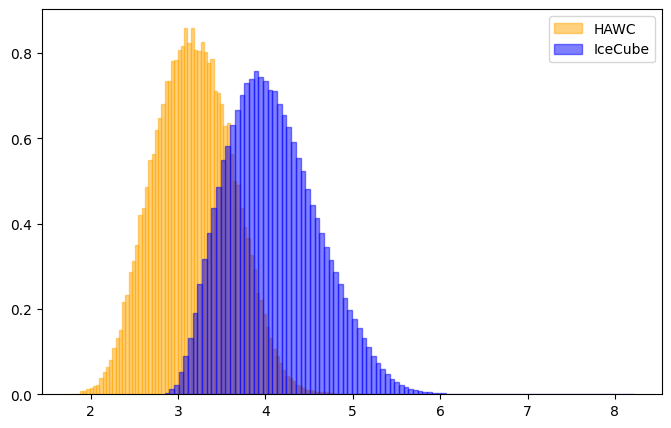

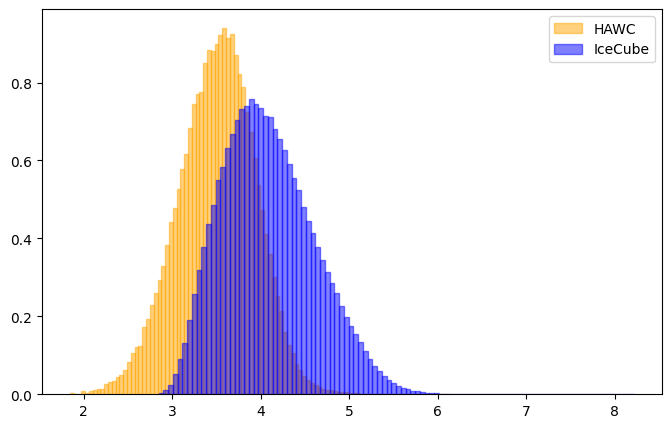

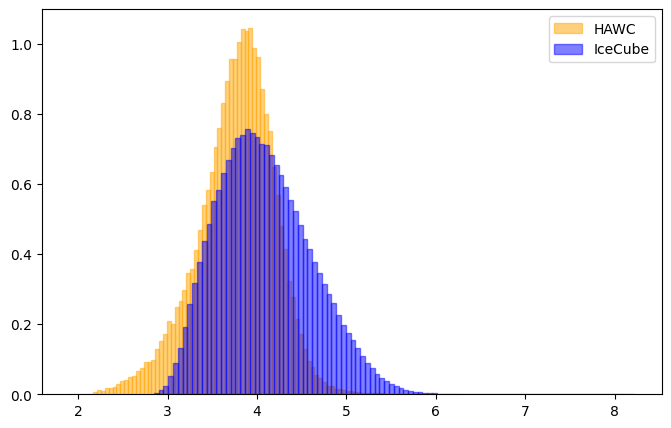

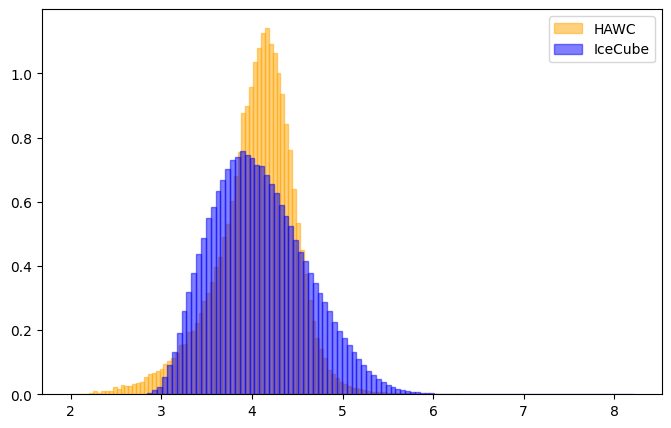

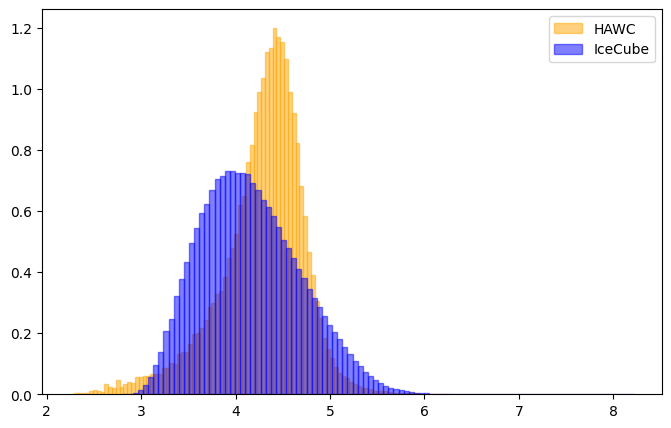

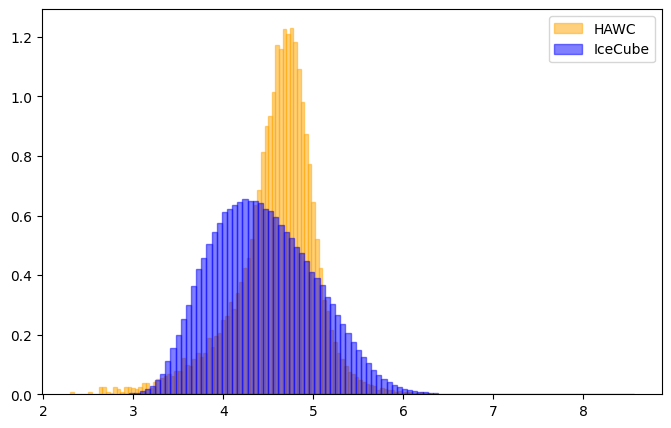

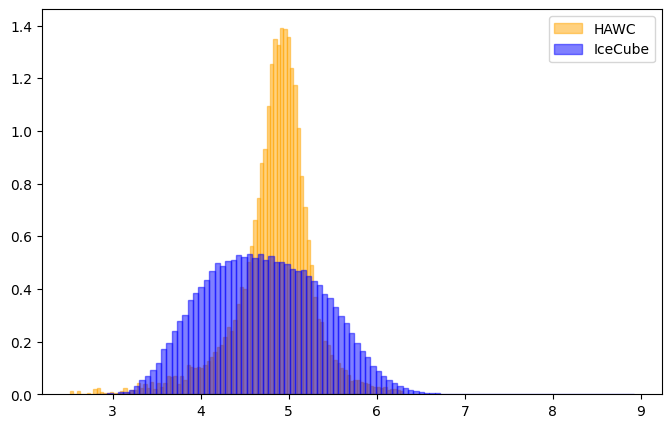

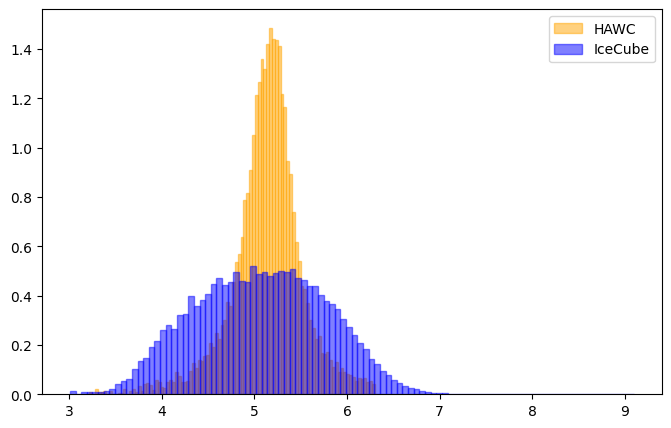

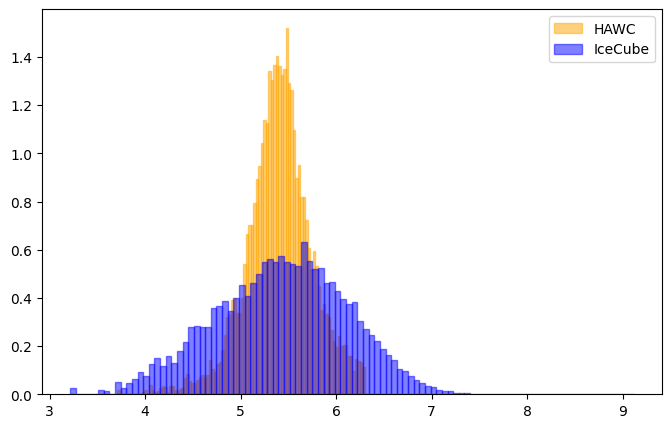

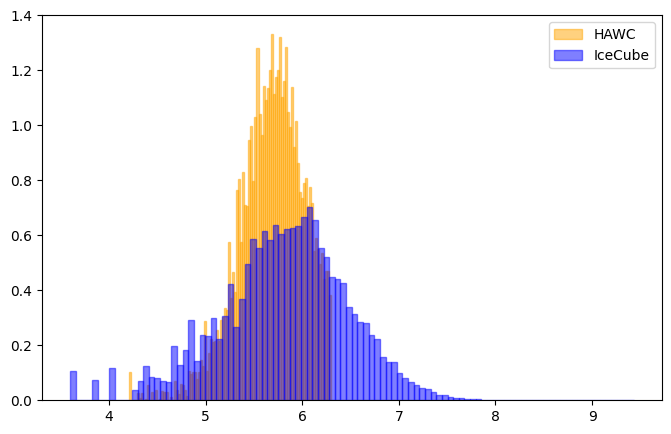

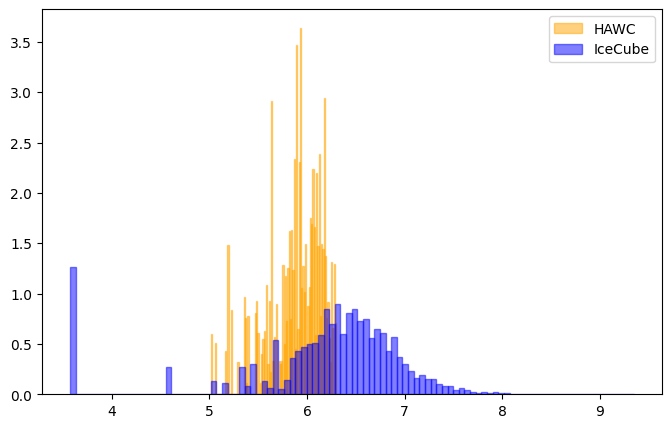

In [42]:
colors = ["red", "blue", "orange", "green", "purple", "pink", "lime", "indigo", "gold", "yellowgreen", "peru", "rosybrown"]

for i, j in zip(cuts, icecube_cuts_gsf):
    plt.figure(figsize = (8,5))
    plt.hist(log_true_E[i], bins = 100, weights = gsf[i], label = 'HAWC', alpha = 0.5, edgecolor = 'orange', color = 'orange', density = True)
    plt.hist(ienergy[j], bins = 100, weights = weights_gsf[j], label = 'IceCube', alpha = 0.5, edgecolor = 'blue', color = 'blue', density = True)
    plt.legend()
    plt.show()

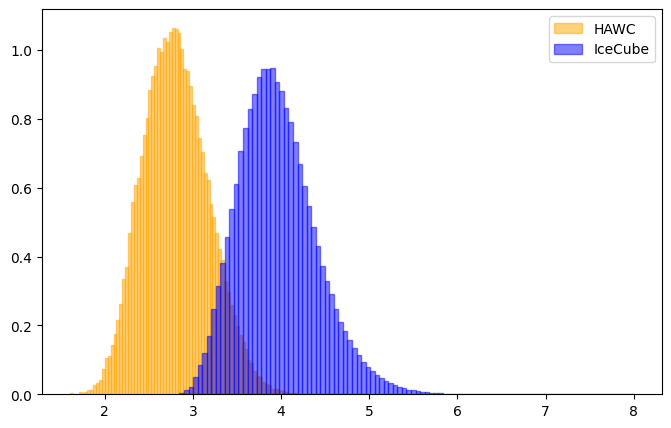

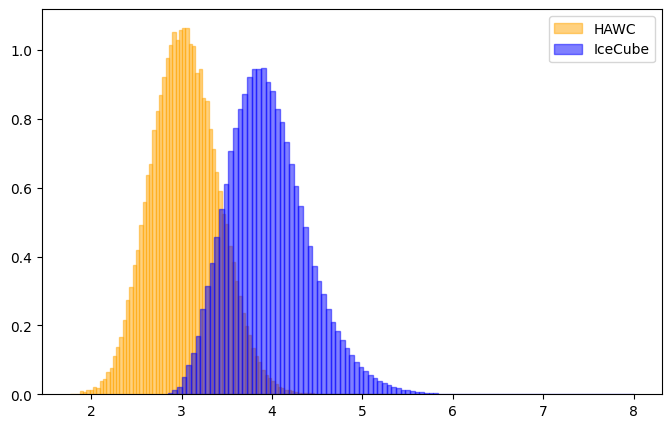

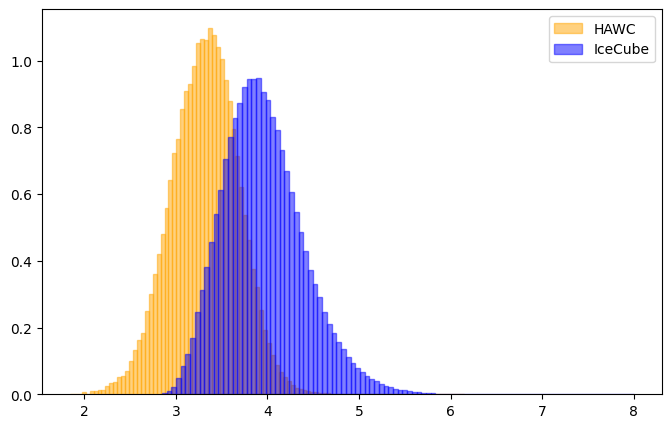

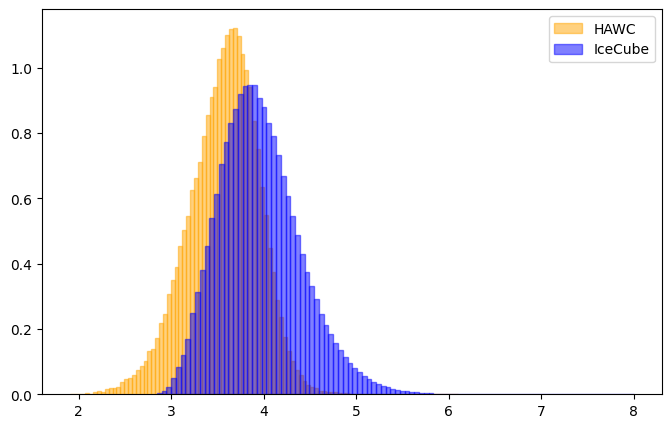

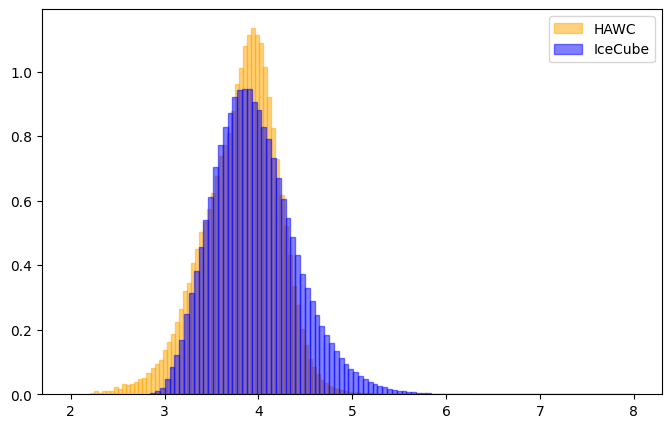

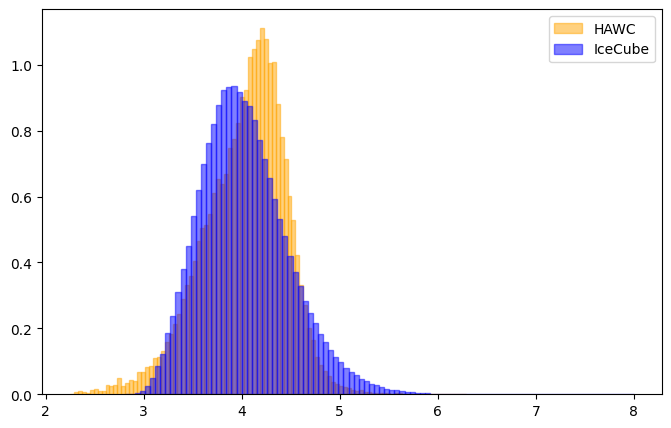

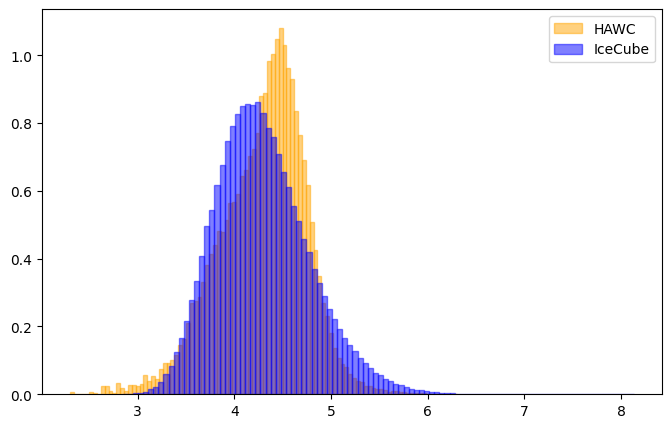

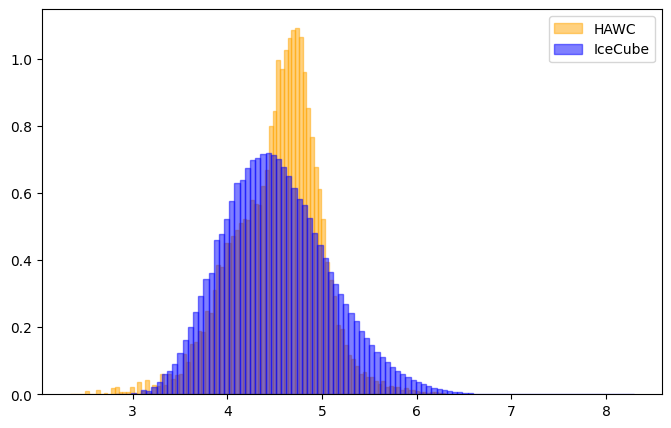

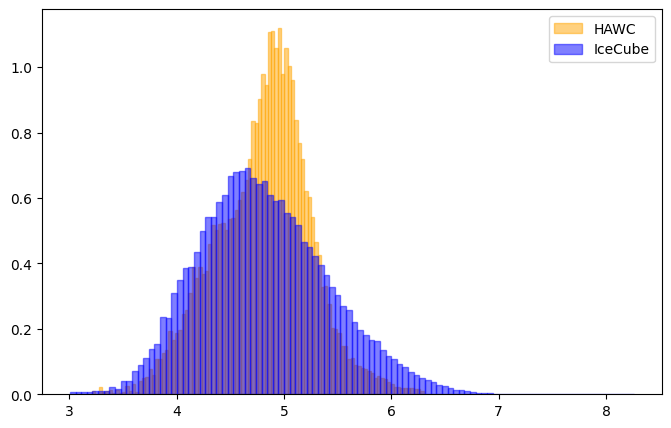

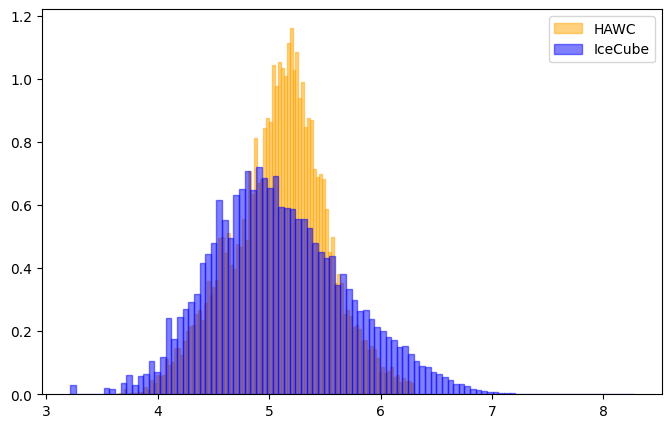

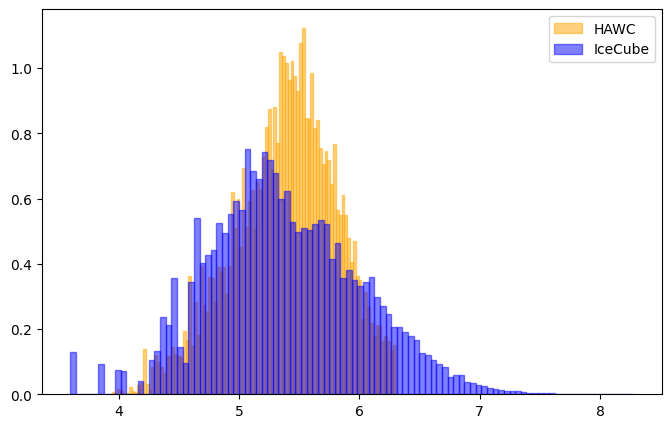

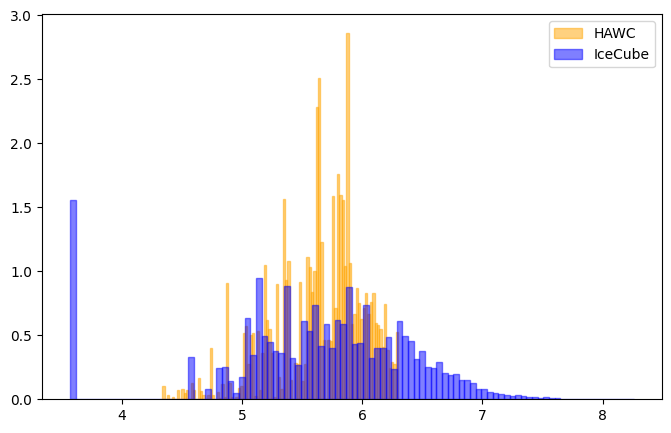

In [43]:
colors = ["red", "blue", "orange", "green", "purple", "pink", "lime", "indigo", "gold", "yellowgreen", "peru", "rosybrown"]

for i, j in zip(cuts, icecube_cuts_gsf):
    plt.figure(figsize = (8,5))
    plt.hist((log_true_E[i] - np.log10(atomic_number[i])), bins = 100, weights = gsf[i], label = 'HAWC', alpha = 0.5, edgecolor = 'orange', color = 'orange', density = True)
    plt.hist((ienergy[j] - np.log10(iatomic[j])), bins = 100, weights = weights_gsf[j], label = 'IceCube', alpha = 0.5, edgecolor = 'blue', color = 'blue', density = True)
    plt.legend()
    plt.show()